# ... más problemas computacionales, ahora algo de zonificación!

Veamos rápidamente, cómo podemos plantear un problema de clasificación para determinar tipos de uso en un área urbana. Para eso, vamos a completar dos grandes pasos:

### 1. Fraccionar nuestro territorio en partes iguales

En esta primera sección vamos a hacer algo que se conoce como `feature engineering`. Esto significa, que vamos a hacer todo el pre-procesamiento necesario para acomodar nuestras variables explicativas (que son las que utilizaremos para responder nuestra pregunta).

Dado que estamos pensando un problema de zonificación, vamos a empezar por construir nuestras zonas de target (aquellas que decidiremos si son residenciales o no).

In [ ]:
# Instalamos dependencias necesarias
!pip install geopandas
!pip install pysal
!pip install h3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 38.0 MB/s 
     |████████████████████████████████| 16.7 MB 11.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 7.3 MB/s 
     |████████████████████████████████| 60 kB 2.1 MB/s 
     |████████████████████████████████| 243 kB 42.2 MB/s 
     |████████████████████████████████| 209 kB 44.1 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 41 kB 374 kB/s 
     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 2.4 MB 18.3 MB/s 
     |████████████████████████████████| 95 kB 2.7 MB/s 
     |████████████████████████████████| 5.7 MB 24.2 MB/s 
   

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/drive/')

Mounted at /drive/


Vamos a levantar el directorio desde donde estamos trabajando para importar los métodos del módulo `h3_geo`. [H3](https://uber.github.io/h3-py/intro.html) es una librería muy interesante para crear grillas hexagonales.

Pusimos algunas herramientas interesantes en este módulo para que podamos crear nuestras zonas.

In [ ]:
import sys
sys.path.append('/drive/MyDrive/Gestion de ciudades/Clase 4 - machine learning')

In [ ]:
from h3_geo import hexgrid_from_shapefile
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Creamos una grilla hexagonal para nuestro problema de clasificacion
url = 'https://storage.googleapis.com/python_mdg/carto_cursos/Polyg_371_centroid.json'
grid = hexgrid_from_shapefile(input_shapefile=url, res = 8).to_crs(4326)

In [ ]:
# Leemos nuestro dataset de propiedades
df = pd.read_csv('/drive/MyDrive/Gestion de ciudades/data/properati/desde_CSV/ar_properties.csv.gz')

In [ ]:
# lo convertimos en un geodataframe de puntos
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'],df['lat']), crs=4326)

In [ ]:
# levantamos una capa de poligonos para filtrar los puntos que caen dentro de San Martin
url = 'https://storage.googleapis.com/python_mdg/carto_cursos/Polyg_371.zip'
polyg = gpd.read_file(url).to_crs(4326)
gdf_sm = gdf.clip(polyg)

In [ ]:
# Nuestro dataset tiene alrededor de 8000 puntos
len(gdf_sm)

7976

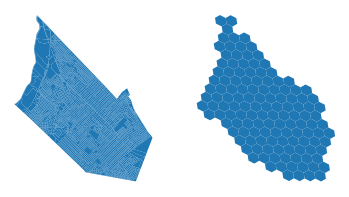

In [ ]:
# esta es la grilla hexagonal que vamos a utilizar
f = plt.figure()
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)

polyg.plot(ax=ax1)
grid.plot(ax=ax2)

ax1.set_axis_off()
ax2.set_axis_off();

In [ ]:
# Verifico los tipos de propiedades
gdf_sm.property_type.unique()

array(['Otro', 'Local comercial', 'Lote', 'Casa', 'PH', 'Depósito',
       'Departamento', 'Oficina', 'Cochera'], dtype=object)

In [ ]:
# Me quedo solo con departamentos y depositos
residencial = ['Departamento']
ofres = gdf_sm.loc[gdf['property_type'].isin(residencial)]
ofres.property_type.value_counts()

Departamento    2936
Name: property_type, dtype: int64

In [ ]:
no_residencial = ['Depósito']
ofnres = gdf_sm.loc[gdf['property_type'].isin(no_residencial)]
ofnres.property_type.value_counts()

Depósito    321
Name: property_type, dtype: int64

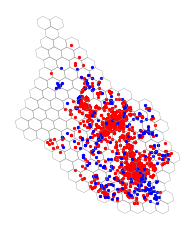

In [ ]:
# Asi se ven nuestras propiedades en la grilla hexagonal
f,ax = plt.subplots()
ofres.plot(ax=ax,color='red', markersize=5)
ofnres.plot(ax=ax, color='blue', markersize=5);
grid.geometry.boundary.plot(ax=ax, linewidth=0.3, color='grey')
ax.set_axis_off();

In [ ]:
# Creo un mismo dataset con la oferta residencial e industrial
ofres['residencial'] = 1
ofnres['industrial'] = 1
oferta = pd.concat([ofres,ofnres])

In [ ]:
# Y le agrego el indice y la geometria de nuestra grilla hexagonal
oferta_grid = gpd.sjoin(oferta, grid[['h3_res_8','geometry']])

In [ ]:
# Cuento cuantos puntos de cada categoria caen dentro de los hexagonos
grid_vals = oferta_grid.groupby('h3_res_8')[['residencial','industrial']].sum()
grid_ = grid.set_index('h3_res_8').join(grid_vals)

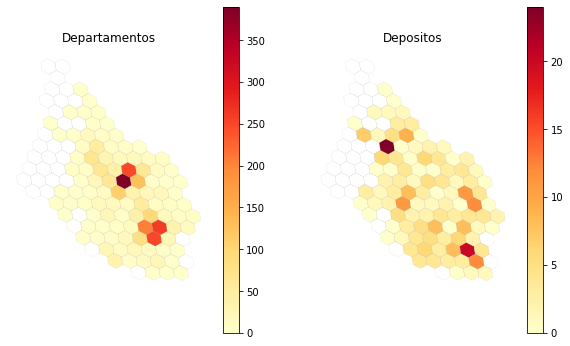

In [ ]:
# Veamos en un mapa como se distribuyen ambas categorias
f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)
grid_.plot(ax=ax1, column='residencial', cmap = 'YlOrRd', legend=True)
grid.geometry.boundary.plot(ax=ax1, linewidth=0.1, color='grey', alpha=0.7)
grid_.plot(ax=ax2, column='industrial', cmap='YlOrRd', legend=True)
grid.geometry.boundary.plot(ax=ax2, linewidth=0.1, color='grey', alpha=0.7)
ax1.set_title('Departamentos')
ax2.set_title('Depositos')
ax1.set_axis_off()
ax2.set_axis_off();

### 2. Creo un modelo para predecir etiquetas de zonificación

#### 2.1. La regresión logística

Las técnicas de clasificación cumplen un rol muy importante en la ciencia de datos. En ese sentido, la `regresión logística` es una de las más utilizadas para resolver problemas de clasificación. Por ejemplo, determinar dentro de un grupo de zonas cuáles son residenciales y no residenciales.

La regresión logística describe y estima la relación entre una variable binaria dependiente y un conjunto de variables independientes. 

Se trata de un método estadístico utilizado para la predicción de clases binarias. En otras palabras, para computar la probabilidad de ocurrencia de un evento. Su resultado es justamente, una variable discreta (0 ó 1).

La regresión logística es un tipo de regresión lineal, pero a diferencia de esta trabaja con MLE. `Maximum Likelihood Estimation` es una función de maximización de probabilidad. 

Maximizar una función de probabilidad implica encontrar los parámetros que tienen mayor probabilidad de producir un evento.

In [ ]:
# Imputo 0 a los valores nulos de las grillas
grid_['residencial'] = grid_['residencial'].fillna(0).astype(int)
grid_['industrial'] = grid_['industrial'].fillna(0).astype(int) 

In [ ]:
# Agrego dos campos nuevos, la lat/lon del centroide de la grilla
grid_['x'] = grid_['geometry'].centroid.x
grid_['y'] = grid_['geometry'].centroid.y

In [ ]:
# Creo una lista a partir de la cantidad de casos de cada tipo
tipos = []
for i in grid_.index:
  if grid_.loc[i, 'residencial'] > grid_.loc[i, 'industrial']:
    tipos.append('residencial')
  elif grid_.loc[i, 'industrial'] > grid_.loc[i, 'residencial']:
    tipos.append('industrial')
  else:
    tipos.append('indefinido')

# Y agrego una nueva columna con los usos predominantes
grid_['tipo'] = tipos

In [ ]:
grid_.tipo.value_counts()

residencial    75
indefinido     36
industrial     20
Name: tipo, dtype: int64

In [ ]:
# Creo una copia de la grilla para usar en el modelado
model_grid = grid_.copy()

In [ ]:
# Residencial va a ser la categoría que vamos a predecir
model_grid['tipo'].replace({'residencial':1, 
                            'industrial':0, 
                            'indefinido':0}, inplace=True)

In [ ]:
# Es nuestro grupo mayoritario
model_grid['tipo'].value_counts()

1    75
0    56
Name: tipo, dtype: int64

In [ ]:
# Nuestras variables explicativas
expvar_names = ['n','residencial','industrial','x','y']

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
# Separo mi dataset en train y test, como tengo pocos datos hago mi set de test lo mas grande posible
X, y = model_grid[expvar_names], model_grid['tipo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=0)

In [ ]:
# Importo la clase "regresion logistica" del paquete sklearn
from sklearn.linear_model import LogisticRegression

# Instancio el modelo,
logreg = LogisticRegression()

# lo entreno con mi set de entrenamiento
logreg.fit(X_train,y_train)

# y predigo!
y_pred=logreg.predict(X_test)

In [ ]:
# Use esta cantidad de casos para entrenar
len(y_test), len(y_pred)

(118, 118)

In [ ]:
# Con la clase metrics voy a evaluar mi modelo
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

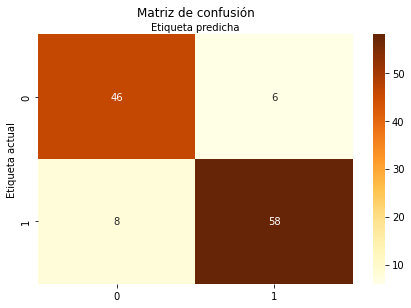

In [ ]:
labels = [0,1] # Estos son los tipos que intente predecir (residencial/no residencial)
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# ploteamos un heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlOrBr" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Etiqueta actual')
plt.xlabel('Etiqueta predicha');

In [ ]:
# Metricas de evaluación
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.8813559322033898
Precision: 0.90625
Recall: 0.8787878787878788


El accuracy nos va a estar indicando el porcentaje total de casos que clasificamos correctamente. 

Precision y Recall van a poner a nuestros resultados en contexto. El primero, teniendo en cuenta el peso de los falsos positivos (VP/VP+FP), el segundo el de los falsos negativos (VP/VP+FN).

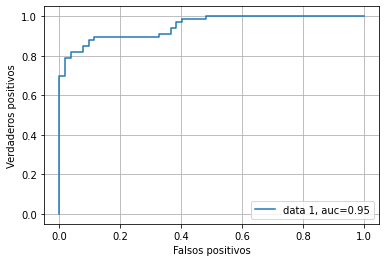

In [ ]:
# Una última referencia de evaluación, la curva ROC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(round(auc,2)))
plt.legend(loc=4)
plt.grid()
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.show()

La curva ROC (Receiver Operating Characteristic) es una comparación entre los ratios de Verdaderos Positivos contra el de Falsos positivos. Más cerca de 1, mejor debería funcionar nuestro clasificador. 0.5 es completa aleatoriedad (como tirar una moneda)

### 3. Y predigo!

In [ ]:
# Aplico mi modelo entrenado sobre mi dataset de grillas hexagonales
preds = logreg.predict(grid_[expvar_names])
grid_['tipo_pred'] = preds

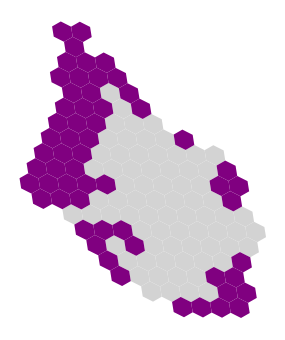

In [ ]:
# Y veo los resultados
f,ax = plt.subplots(figsize=(10,6))
grid_.loc[grid_['tipo_pred']==1].plot(ax=ax, color='lightgrey')
grid_.loc[grid_['tipo_pred']==0].plot(ax=ax, color='purple')
ax.set_axis_off()